In [1]:
import numpy as np

# cut texts after this number of words
# (among top max_features most common words)
print("Defining constants...")

PREDIR=r'.\\'
#MFCC_FEATURES = 20 # 20 MFCC features (along the frequency axis)
PRAAT_SPEC=160
SPEC_FEATURES = 32
SPEC_LEN = 160
#HALF_SPEC=10
HOP_LENGTH=200
#TIME_STEP = 0.001
TIME_STRIDE=3
TIME_LEN = 10
BATCH_SIZE = 1 # Sample per training
EPOCH=10000
LATENT_NUM=200
SAMPLE_LEN=20
STEPS_PER_EPOCH=20
SPEC_STEP=5
WINDOW_LEN=0.005
RANDTH=0.1
LIBROSA_FREQ_BIN=128
LABELS=['sp', 'a', 'e', 'f', 'i', 'j', 'k', 'kʰ', 'l', 'm', 'n', 'o', 'p', 'pʰ', 's', 't', 'ts', 'tsʰ', 'tɕ', 'tɕʰ', 
       'tʂ', 'tʂʰ', 'tʰ', 'u', 'w', 'x', 'y', 'ŋ', 'ɔ', 'ɕ', 'ə', 'ɚ', 'ɛ', 'ɤ', 'ɥ', 'ɨ', 'ʂ', 'ʐ']
NUM_CLASSES = len(LABELS)
LSTM_OUTPUT = NUM_CLASSES * 4

DATA = np.array(LABELS)
#print(DATA)
HOP_LEN = 512
NFFT = 2048
INT_MAPPING = {x: i for i,x in enumerate(LABELS)}
print(INT_MAPPING)

%matplotlib inline

Defining constants...
{'sp': 0, 'a': 1, 'e': 2, 'f': 3, 'i': 4, 'j': 5, 'k': 6, 'kʰ': 7, 'l': 8, 'm': 9, 'n': 10, 'o': 11, 'p': 12, 'pʰ': 13, 's': 14, 't': 15, 'ts': 16, 'tsʰ': 17, 'tɕ': 18, 'tɕʰ': 19, 'tʂ': 20, 'tʂʰ': 21, 'tʰ': 22, 'u': 23, 'w': 24, 'x': 25, 'y': 26, 'ŋ': 27, 'ɔ': 28, 'ɕ': 29, 'ə': 30, 'ɚ': 31, 'ɛ': 32, 'ɤ': 33, 'ɥ': 34, 'ɨ': 35, 'ʂ': 36, 'ʐ': 37}


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
import matplotlib.pyplot as plt
from scipy import spatial
import math

def npplot(x, y, x2, y2, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.plot(x2, y2, "xr")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def windows_clip(idx, winsize, num):
    print()
    
def cosine_similarity(data):
    cosslist = []
    timeser = []
    #print(data.shape)
    for i in range(data.shape[1]-1):
        u = data[:,i]/np.linalg.norm(data[:,i])
        v = data[:,i+1]/np.linalg.norm(data[:,i+1])
        coss = spatial.distance.cosine(u, v)
        cosslist.append(coss)
        timeser.append(i*0.01)
        #print( "{:.3f}".format(coss), end=" ")        
    #print(i)
    return timeser, cosslist

VIC=5

def cos_loss(data):
    cosslist = []
    timeser = []
    
#    for i in range(VIC):
#        cosslist.append(0)
#        timeser.append(i*0.01)

    #print(data.shape)
    for i in range(VIC, data.shape[1]-1-VIC):
        upper = math.exp(np.inner(data[:,i], data[:,i+1])/(np.linalg.norm(data[:,i])*np.linalg.norm(data[:,i+1])))
                         
        lower = 0
        for j in range(i-VIC, i+VIC):
            for k in range (j, i+VIC):
                if j != i and k != i+1:
                    lower = lower + math.exp(np.inner(data[:,j], data[:,k])/(np.linalg.norm(data[:,j])*np.linalg.norm(data[:,k])))
   
        coss = upper/lower
        cosslist.append(coss)
        timeser.append(i*0.01)
        
    #for i in range(VIC -1):
    #    cosslist.append(0)
    #    timeser.append(i*0.01)
        
    #print( "{:.3f}".format(coss), end=" ")        
    #print(i)
    return timeser, cosslist

def sum_distance(data):
    cosslist = []
    timeser = []
    
    #print(data.shape)
    for i in range(VIC-1, data.shape[1]-1-VIC):
        sum1 = np.empty(data.shape[0])
        for j in range(VIC):
            sum1 = sum1 + data[:,i-j]

        sum2 = np.empty(data.shape[0])
        for j in range(VIC):
            sum2 = sum2 + data[:,(i+1) + j]
        
        usum1 = sum1 / np.linalg.norm(sum1)
        usum2 = sum2 / np.linalg.norm(sum2)
        #print(sum1, sum2)
        coss = spatial.distance.cosine(usum1, usum2)
        cosslist.append(coss)
        timeser.append(i*0.01)
        
    #for i in range(VIC -1):
    #    cosslist.append(0)
    #    timeser.append(i*0.01)
        
    #print( "{:.3f}".format(coss), end=" ")        
    #print(i)
    return timeser, cosslist

def group_cos_sim(data):
    cosslist = []
    timeser = []
        
    for i in range(VIC-1,data.shape[1]-VIC-1):
        totcoss = 0
        for j in range(VIC):
            cossij = spatial.distance.cosine(data[:,i-j], data[:,i+1])
            totcoss = totcoss + cossij
        for j in range(VIC):
            cossij = spatial.distance.cosine(data[:,i], data[:,i+j+1])
            totcoss = totcoss + cossij
        cosslist.append(totcoss)
        timeser.append(i*0.01)
        #print( "{:.3f}".format(totcoss), end=" ")

#    for i in range(VIC):
#        cosslist.append(0)
#        timerser.append(i*0.01)

    return timeser, cosslist

def group_sum_cos_sim(data):
    cosslist = []
    timeser = []
    
        
    for i in range(VIC-1,data.shape[1]-VIC-1):
        totcoss = 0
        for j in range(VIC):
            cossij = spatial.distance.cosine(data[:,i-j], data[:,i+1])
            totcoss = totcoss + cossij/pow(2,j)
        for j in range(VIC):
            cossij = spatial.distance.cosine(data[:,i], data[:,i+j+1])
            totcoss = totcoss + cossij/pow(2,j)
        cosslist.append(totcoss)
        timeser.append(i*0.01)
    return timeser, cosslist

In [4]:
from scipy.io.wavfile import read #import the required function from the module
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def wavplot(file):
    samplerate, data = read(file)
    duration = len(data)/samplerate
    time = np.arange(0,duration,1/samplerate) #time vector
    time2=np.resize(time, pdata.shape)
    
    npplot(time2, pdata, 'Time [s]', 'Amplitude', file)

def librosawavplot(file):
    data, samplerate = librosa.load(file)
    pdata = data/np.sqrt(np.sum(np.square(data))/data.size)
    
    duration = len(data)/samplerate
    time = np.arange(0,duration,1.0/samplerate) #time vector
    
    time2=np.resize(time, pdata.shape)
    #print(time2.shape)
    #print(data.shape)
    npplot(time2, pdata, 'Time [s]', 'Amplitude', file)

def librosamfccplot(file):
    y, sr = librosa.load(file,sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=24)
    print("mfccs shape", mfccs.shape)
    fig, ax = plt.subplots()
    img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
    #fig.colorbar(img, ax=ax)
    ax.set(title='MFCC '+file)

    m_slaney = librosa.feature.mfcc(y=y, sr=sr, dct_type=2, n_mfcc=24)
    print("mfccs_dct shape", m_slaney.shape)

    m_htk = librosa.feature.mfcc(y=y, sr=sr, dct_type=3, n_mfcc=24)
    print("mfccs_htk shape", m_htk.shape)

    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
    img1 = librosa.display.specshow(m_slaney, x_axis='time', ax=ax[0])
    ax[0].set(title='RASTAMAT / Auditory toolbox (dct_type=2) '+file)
    #fig.colorbar(img, ax=[ax[0]])
    img2 = librosa.display.specshow(m_htk, x_axis='time', ax=ax[1])
    ax[1].set(title='HTK-style (dct_type=3) '+file)
    #fig.colorbar(img2, ax=[ax[1]])
    plt.show()


In [5]:
FRAME_SIZE=512
WIN_SIZE= 10 # 10 ms

def combined_plot(Y, sr, hop_length, file, time, coss, y_axis="linear"):
    #plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, sr=sr, hop_length=hop_length, x_axis="time", y_axis=y_axis)
    #plt.colorbar(format="%+2.f")
    plt.plot(time, coss)
    plt.title(file)
    plt.show()
    
def plot_spectrogram(Y, sr, hop_length, file, y_axis="linear"):
    #plt.figure(figsize=(25, 10))
    librosa.display.specshow(Y, sr=sr, hop_length=hop_length, x_axis="time", y_axis=y_axis)
    #plt.colorbar(format="%+2.f")
    plt.title(file)
    plt.show()

def plot_maxpooling_spec(Y, sr, hop_length, file, y_axis="linear"):
    plot_spectrogram(YMP, sr, hop_length*2, file, y_axis)
    
def get_maxpool_spectrogram(file, needplot=True):
    ylog, sr = get_spectrogramplot(file, needplot=False)
    YMP = skimage.measure.block_reduce(Y, (2,2), np.max)
    if needplot:
        plot_spectogram(YMP, sr, HOP_SIZE, file=file, y_axis="log")
    
def spectrogramplot(file, needplot=True):
    y, sr= librosa.load(file)
    HOP_SIZE= int(WIN_SIZE / (1/sr *1000))
    sff = librosa.stft(y, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
    print(sff.shape)
    ysff = np.abs(sff) ** 2
    ylog = librosa.power_to_db(ysff)
    #print(ylog.shape)
    
    if needplot:
        plot_spectrogram(ylog, sr, HOP_SIZE, file=file, y_axis="log")

    return ylog, sr, HOP_SIZE


In [6]:
import tgt
import os

class mytextgrid:
    def __init__(self, filename="peak.textgrid"):
        if os.path.isfile(filename):
            self.tg = tgt.io.read_textgrid(filename)
        else:
            self.tg = tgt.core.TextGrid()
        
    def add_tier(self, name, duration, peak):
        peaktier = tgt.core.IntervalTier(0, duration, name)
        self.tg.add_tier(peaktier)

        for idx in range(len(peak)):
            if idx == 0:
                ann = tgt.core.Annotation(0, peak[idx], "")
            elif idx == len(peak) - 1:
                ann = tgt.core.Annotation(peak[idx], duration, "")
            else:
                ann = tgt.core.Annotation(peak[idx], peak[idx+1], "")
            peaktier.add_annotation(ann)
        return self.tg

    def export(self, filename):
        tgt.io.write_to_file(self.tg, filename)
    
#tg = mytextgrid('1289-00_001.textgrid')
#peak=[3, 6, 13, 22, 32,38, 45, 48, 54, 62, 64, 84, 89, 93, 106, 109, 111, 113, 142, 209, 215, 236, 240, 252, 261, 274, 298]
#peakx = [x / 100. for x in peak]
#tg.add_tier('peak', 3.049705, peakx)
#tg.export('peak.textgrid')

#print(tg)

(257, 306)


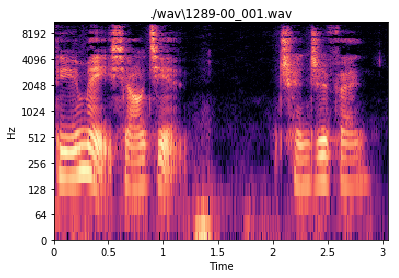

[  2  37  47  53  88 108 141 208 212 235 260]


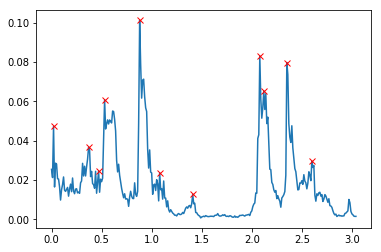

[ 29  46  61  81  91 202 205 213 229 237 258]


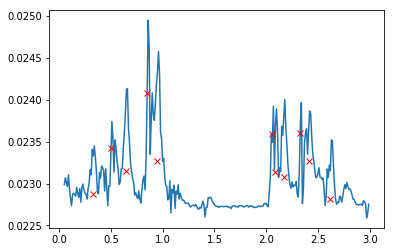

[ 18  27  33  37  47  51  57  67  78  85  89 200 205 210 216 222 232 237
 241 245 257 271]


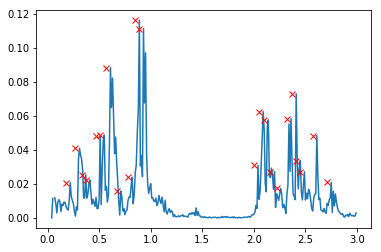

[ 17  29  49  57  85 104 108 138 205 210 233 247 256 293]


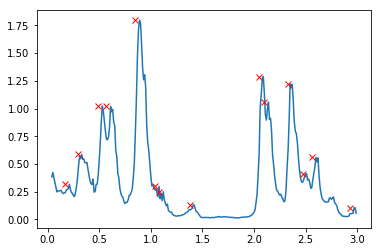

In [7]:
import glob
import os
from scipy.signal import find_peaks


#dirpref=r"/content/drive/MyDrive/Colab Notebooks/us-travel/1289-00/*"
#dirpref=r"z:/TIMIT/Audiobooks/旅美小簡/1289-00-pad/*"
dirpref=r"./wav/*.wav"
#os.chdir(r'z:\\TIMIT\\Audiobooks\\旅美小簡\\1289-00\\')
def plotspec():
    elef2 = glob.glob(dirpref)
    #print(elef2)
    for f in elef2:
        #wavplot(f)
        #librosawavplot(f)
        #librosamaxpoolingplot(f)
        #librosamfccplot(f)
        #tgfname = f[:-3]+'textgrid'
        #peaktg = mytextgrid(tgfname)
        peaktg = mytextgrid(f[:-3]+'TextGrid')
        dur = librosa.get_duration(filename=f)
        
        ylog, sr, hop = spectrogramplot(f, needplot=True)

        tr, coss = cosine_similarity(ylog)
        #combined_plot(ylog, sr, hop, f, tr, coss, y_axis="log")
        peaks, _ = find_peaks(coss, distance=3, height = 0.01, prominence=0.01)
        #peaks, _ = find_peaks(coss, distance=10)
        print(peaks)
        cosspeaks = [coss[index] for index in peaks]
        peaks = peaks/100
        npplot(tr, coss, peaks, cosspeaks, "", "", "")
        peaktg.add_tier('SimpPeak', dur, peaks)
        
        tr, coss = cos_loss(ylog)
        #combined_plot(ylog, sr, hop, f, tr, coss, y_axis="log")
        peaks, _ = find_peaks(coss, distance=3, prominence=0.0005)
        print(peaks)
        peaks = peaks + VIC-1
        cosspeaks = [coss[index] for index in peaks]
        peaks = peaks/100
        npplot(tr, coss, peaks, cosspeaks, "", "", "")
        peaktg.add_tier('LossPeak', dur, peaks)

        tr, coss = sum_distance(ylog)
        #combined_plot(ylog, sr, hop, f, tr, coss, y_axis="log")
        peaks, _ = find_peaks(coss, distance = 3, height = 0.01, prominence=0.01)
        #peaks, _ = find_peaks(coss, distance=10)
        print(peaks)
        cosspeaks = [coss[index] for index in peaks]
        peaks = peaks/100
        npplot(tr, coss, peaks, cosspeaks, "", "", "")
        peaktg.add_tier('SumPeak', dur, peaks)
        
        tr, coss = group_cos_sim(ylog)
        #combined_plot(ylog, sr, hop, f, tr, coss, y_axis="log")
        peaks, _ = find_peaks(coss, distance = 3, height = 0.01, prominence=0.01*VIC)
        #peaks, _ = find_peaks(coss, distance=10)
        print(peaks)
        cosspeaks = [coss[index] for index in peaks]
        peaks = peaks/100
        npplot(tr, coss, peaks, cosspeaks, "", "", "")
        peaktg.add_tier('GroupPeak', dur, peaks)
        
        peaktg.export(f[:-3]+'PekGid')
        
plotspec()

In [ ]:
import skimage.measure

def librosamaxpoolingplot(file):
    origdata, samplerate = librosa.load(file)
    print(origdata.shape)
    data = skimage.measure.block_reduce(origdata, (2,2), np.max)
    duration = len(origdata)/(samplerate) * 3
    time = np.arange(0, duration, 1.0/samplerate) #time vector
    
    time2=np.resize(time, data.shape)
    #print(time2.shape)
    #print(data.shape)
    
    plt.plot(time2,data)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title(file)
    plt.show()


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = (24, 24, 1)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)

model.summary()